In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline

import gpx

# Learning adiabatic energies through an (unknown) diabatization

This notebook is a proof-of-principle / illustration of the idea to learn adiabatic energies through an unknown diabatization
The idea is that adiabatic energies can be learned more efficiently, and all together on the same ground, if one predicts the diabatic hamiltonian and then diagonalizes it to obtain the adiabatic energies

We use a simple toy model used by [Thrular and coworkers](https://pubs.acs.org/doi/pdf/10.1021/acs.jctc.0c00623) to demonstrate their own ML approach to diabatization.

In [138]:
def thrular_2states_dataset(x):
    """Generate a 2-states avoided crossing dataset
    
    This dataset is the one used in "Diabatization by Machine Intelligence"
    https://pubs.acs.org/doi/pdf/10.1021/acs.jctc.0c00623
    """
    u11 = lambda x: 28.0 - x
    u22 = lambda x: x
    u12 = lambda x: jnp.exp(-0.3*(x - 14.0)**2)
    mats = []
    for xx in x:
        mats.append(jnp.array([[u11(xx), u12(xx)], [u12(xx), u22(xx)]]))
    mats = jnp.array(mats)
    return mats

In [34]:
# input features
x = jnp.arange(11.0, 17.0, 0.1)

# diabatic matrices
y_diaba = thrular_2states_dataset(x)

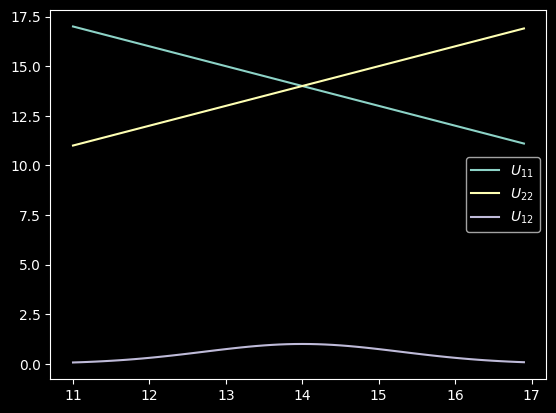

In [35]:
plt.plot(x, y_diaba[:, 0, 0], label=r'$U_{11}$')
plt.plot(x, y_diaba[:, 1, 1], label=r'$U_{22}$')
plt.plot(x, y_diaba[:, 0, 1], label=r'$U_{12}$')
plt.legend()

We suppose that we only have access to the adiabatic energies

In [36]:
y_adia = jnp.linalg.eigvalsh(y_diaba)

y_adia.shape

(60, 2)

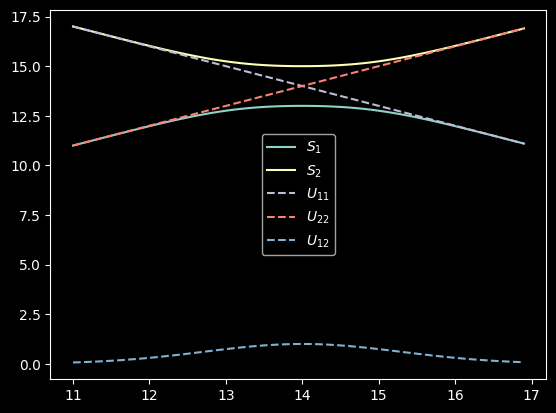

In [46]:
plt.plot(x, y_adia[:, 0], label=r'$S_{1}$')
plt.plot(x, y_adia[:, 1], label=r'$S_{2}$')
plt.plot(x, y_diaba[:, 0, 0], label=r'$U_{11}$', ls='dashed')
plt.plot(x, y_diaba[:, 1, 1], label=r'$U_{22}$', ls='dashed')
plt.plot(x, y_diaba[:, 0, 1], label=r'$U_{12}$', ls='dashed')
plt.legend()
plt.legend()

Let's split into train and test sets

In [55]:
indices = jnp.arange(x.shape[0])
train_indices = indices[::3]
test_indices = jnp.setdiff1d(indices, train_indices)

x_train = x[train_indices].reshape(-1, 1)
x_test = x[test_indices].reshape(-1, 1)

y_adia_train = y_adia[train_indices]
y_adia_test = y_adia[test_indices]

Let's split also the diabatic hamiltonians, to check them later

In [57]:
y_diaba_train = y_diaba[train_indices]
y_diaba_test = y_diaba[test_indices]

Our model will be a Radial Basis Function network, which is essentially a Gaussian Process / Kernel Ridge regressor.
On top of that, we put a transformation layer that takes as input the prediction of the regressor, performs the diagonalization, and outputs the adiabatic energies. This makes the model nonlinear in the expansion coefficients, and allows to learn an intermediate prediction (the diabatic hamiltonian) for which we have no reference data.

In [58]:
def diabatization_layer(pred: jnp.ndarray) -> jnp.ndarray:
    # n = number of samples
    n, _ = pred.shape
    diaba_hamil = jnp.zeros((n, 2, 2))
    diaba_hamil = diaba_hamil.at[:, 0, 0].set(pred[:, 0])
    diaba_hamil = diaba_hamil.at[:, 1, 1].set(pred[:, 1])
    diaba_hamil = diaba_hamil.at[:, 0, 1].set(pred[:, 2])
    diaba_hamil = diaba_hamil.at[:, 1, 0].set(pred[:, 2])
    return jnp.linalg.eigvalsh(diaba_hamil)

At this point we can instantiate the model. The default loss function is the mean squared error with L2 regularization

In [127]:
from gpx.models.rbfnet import RBFNet
from gpx.kernels import SquaredExponential
from gpx.parameters import Parameter
from gpx.priors import NormalPrior
from gpx.utils import softplus, inverse_softplus, identity

`softplus` (and `inverse_softplus`) are used to ensure that the desired parameters are always positive. `identity` is the null operation.

Note that the `inducing_points` are provided as a `gpx.Parameter`, since in principle it is possible to optimize also the incuding points.
Note also that `inducing_points` can be different from the train set features. One can select, e.g., a subset of them with FPS or CUR or whatever, and build a sparse RBFNet.

`num_output` is set to 3 as we predit the two diagonal and the off-diagonal elements of the diabatic Hamiltonian.

In [128]:
model = RBFNet(
    key=jax.random.PRNGKey(2023),
    kernel=SquaredExponential(),
    inducing_points=Parameter(x_train, False, identity, identity, NormalPrior(shape=x_train.shape)),
    num_output=3,
    output_layer=diabatization_layer,
)

Always good to check if the model is instantiated correctly

In [129]:
model.print()

┌────────────────────┬─────────────┬───────────┬──────────────────┬───────────────────────┬───────────┬─────────┬─────────┬─────────────────────────────────┐
│ name               │ trainable   │ forward   │ backward         │ prior                 │ type      │ dtype   │ shape   │ value                           │
├────────────────────┼─────────────┼───────────┼──────────────────┼───────────────────────┼───────────┼─────────┼─────────┼─────────────────────────────────┤
│ kernel lengthscale │ True        │ softplus  │ inverse_softplus │ NormalPrior(0.0, 1.0) │ ArrayImpl │ float64 │ ()      │ 1.                              │
├────────────────────┼─────────────┼───────────┼──────────────────┼───────────────────────┼───────────┼─────────┼─────────┼─────────────────────────────────┤
│ alpha              │ True        │ softplus  │ inverse_softplus │ NormalPrior(0.0, 1.0) │ ArrayImpl │ float64 │ ()      │ 1.                              │
├────────────────────┼─────────────┼───────────┼────

Fit (with SciPy's L-BFGS-B)

In [130]:
model.fit(x_train, y_adia_train)

Check that what should be optimized has been really optimized (and vice-versa)

In [131]:
model.print()

┌────────────────────┬─────────────┬───────────┬──────────────────┬───────────────────────┬───────────┬─────────┬─────────┬───────────────────────────────────┐
│ name               │ trainable   │ forward   │ backward         │ prior                 │ type      │ dtype   │ shape   │ value                             │
├────────────────────┼─────────────┼───────────┼──────────────────┼───────────────────────┼───────────┼─────────┼─────────┼───────────────────────────────────┤
│ kernel lengthscale │ True        │ softplus  │ inverse_softplus │ NormalPrior(0.0, 1.0) │ ArrayImpl │ float64 │ ()      │ 4.04828687                        │
├────────────────────┼─────────────┼───────────┼──────────────────┼───────────────────────┼───────────┼─────────┼─────────┼───────────────────────────────────┤
│ alpha              │ True        │ softplus  │ inverse_softplus │ NormalPrior(0.0, 1.0) │ ArrayImpl │ float64 │ ()      │ 3.05227783e-38                    │
├────────────────────┼─────────────┼────

Check that the adiabatic energies are learned correctly

Text(0.5, 1.0, 'Train')

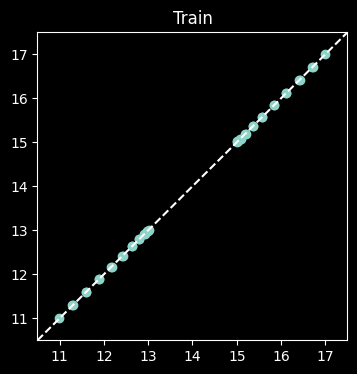

In [132]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(model.predict(x_train), y_adia_train)
ax.plot([0, 1], [0, 1], ls='dashed', transform=ax.transAxes, c='w')
ax.set_xlim(10.5, 17.5)
ax.set_ylim(10.5, 17.5)
ax.set_title('Train')

Text(0.5, 1.0, 'Test')

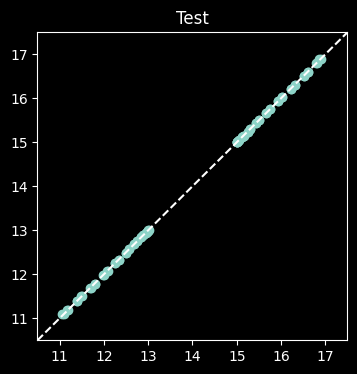

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(model.predict(x_test), y_adia_test)
ax.plot([0, 1], [0, 1], ls='dashed', transform=ax.transAxes, c='w')
ax.set_xlim(10.5, 17.5)
ax.set_ylim(10.5, 17.5)
ax.set_title('Test')

Text(0.5, 1.0, 'Test')

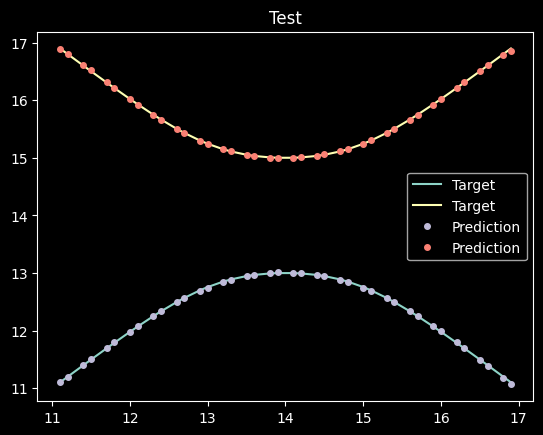

In [134]:
plt.plot(x_test, y_adia_test, label='Target')
plt.plot(x_test, model.predict(x_test), 'o', ms=4, label='Prediction')
plt.legend()
plt.title('Test')

We can predict the diabatic hamiltonian by turning off the diabatization layer during the prediction.
We can do this setting the `linear_only`

In [135]:
y_diaba_test_pred = model.predict(x_test, linear_only=True)

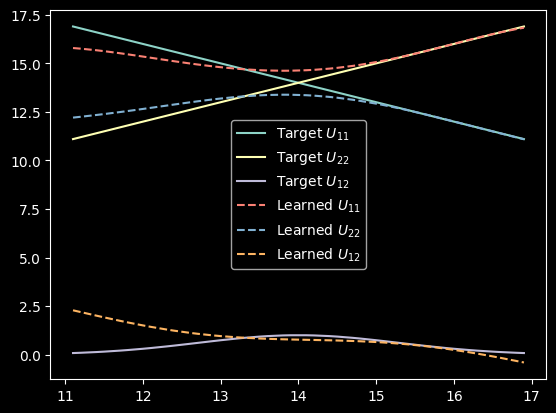

In [136]:
plt.plot(x_test, y_diaba[test_indices][:, 0, 0], label=r'Target $U_{11}$')
plt.plot(x_test, y_diaba[test_indices][:, 1, 1], label=r'Target $U_{22}$')
plt.plot(x_test, y_diaba[test_indices][:, 0, 1], label=r'Target $U_{12}$')
plt.plot(x_test, y_diaba_test_pred[:, 0], label=r'Learned $U_{11}$', ls='dashed')
plt.plot(x_test, y_diaba_test_pred[:, 1], label=r'Learned $U_{22}$', ls='dashed')
plt.plot(x_test, y_diaba_test_pred[:, 2], label=r'Learned $U_{12}$', ls='dashed')
plt.legend()

This model can be improved in many ways, e.g., by including some diabatic states in the loss, by enforcing the diabatic prediction to be smooth, by enforcing symmetries in the diabatic prediction, putting a loss on the diabatic coupling, including NACs, ...